In [291]:
%%bash

cd ~
cd Documents/forceatlas2

python /Users/rk1103/Documents/forceatlas2/setup.py  install

Installing fa2 package (fastest forceatlas2 python implementation)
running install
running bdist_egg
running egg_info
writing fa2.egg-info/PKG-INFO
writing dependency_links to fa2.egg-info/dependency_links.txt
writing requirements to fa2.egg-info/requires.txt
writing top-level names to fa2.egg-info/top_level.txt
reading manifest file 'fa2.egg-info/SOURCES.txt'
reading manifest template 'MANIFEST.in'
writing manifest file 'fa2.egg-info/SOURCES.txt'
installing library code to build/bdist.macosx-10.9-x86_64/egg
running install_lib
running build_py
copying fa2/fa2util.c -> build/lib.macosx-10.9-x86_64-3.9/fa2
running build_ext
creating build/bdist.macosx-10.9-x86_64/egg
creating build/bdist.macosx-10.9-x86_64/egg/fa2
copying build/lib.macosx-10.9-x86_64-3.9/fa2/fa2util.py -> build/bdist.macosx-10.9-x86_64/egg/fa2
copying build/lib.macosx-10.9-x86_64-3.9/fa2/fa2util.cpython-39-darwin.so -> build/bdist.macosx-10.9-x86_64/egg/fa2
copying build/lib.macosx-10.9-x86_64-3.9/fa2/__init__.py -> bui

zip_safe flag not set; analyzing archive contents...


In [1]:
import pgmpy
import bnlearn
from pomegranate import *
import pandas as pd
from pgmpy.estimators import PC, HillClimbSearch, ExhaustiveSearch, TreeSearch
from pgmpy.estimators.CITests import chi_square
from pgmpy.estimators import K2Score, BDeuScore, BicScore
from pgmpy.utils import get_example_model
from pgmpy.sampling import BayesianModelSampling
import networkx as nx
from pgmpy.models import BayesianModel
from pgmpy.estimators import MaximumLikelihoodEstimator, BayesianEstimator
import pylab as plt
from iteration_utilities import duplicates
import numpy as np
from operator import itemgetter, attrgetter
from networkx.algorithms import tree, community

import fa2

In [2]:
# stanford dataset network site https://snap.stanford.edu/data

df = pd.read_csv("../data/git_web_ml/musae_git_edges.csv")
df = df.rename(columns={'id_1': 'source', 'id_2': 'target'})
Graphtype = nx.Graph()
G = nx.from_pandas_edgelist(df,  create_using=Graphtype)
#print(nx.info(G))
#G.edges

In [3]:
len(list(G.edges))
v = list(G.edges)
#list(duplicates(v))
degree_sorted = sorted(G.degree(), key=lambda x: x[1], reverse=True)

#keep top 30 nodes 

node_list_remove = [node for node, v in degree_sorted[1000::]]
G.remove_nodes_from(node_list_remove)
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 1000
Number of edges: 25591
Average degree:  51.1820


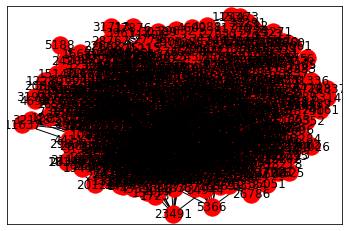

In [4]:


# network of github users with 1000 mutual followers 
nx.draw_networkx(G, node_color='red')

In [5]:
mst = tree.maximum_spanning_edges(G, algorithm="kruskal", data=False)
edgelist = list(mst)
sorted(sorted(e) for e in edgelist)
len(edgelist)

999

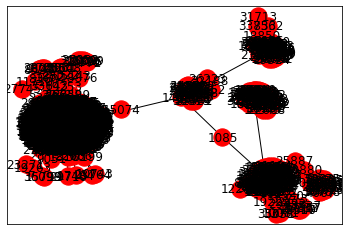

In [6]:
G = nx.Graph()
G.add_edges_from(edgelist)  # using a list of edge tuples
nx.info(G)
# pruned network after Max weighted spanning tree algo

pos = nx.spring_layout(G)
nx.draw_networkx(G, pos=pos,node_color='red')

In [7]:
degree_dict = dict(G.degree(G.nodes()))
betweenness_dict = nx.betweenness_centrality(G) # Run betweenness centrality
#eigenvector_dict = nx.eigenvector_centrality(G) # Run eigenvector centrality

nx.set_node_attributes(G, degree_dict, 'degree')
# Assign each to an attribute in your network
nx.set_node_attributes(G, betweenness_dict, 'betweenness')
#nx.set_node_attributes(G, eigenvector_dict, 'eigenvector')

communities = community.greedy_modularity_communities(G)


modularity_dict = {} # Create a blank dictionary
for i,c in enumerate(communities): # Loop through the list of communities, keeping track of the number for the community
    for name in c: # Loop through each person in a community
        modularity_dict[name] = i # Create an entry in the dictionary for the person, where the value is which group they belong to.

# Now you can add modularity information like we did the other metrics
nx.set_node_attributes(G, modularity_dict, 'modularity')


sorted_betweenness = sorted(betweenness_dict.items(), key=itemgetter(1), reverse=True)

#First get the top 20 nodes by betweenness as a list
top_betweenness = sorted_betweenness[:20]

#Then find and print their degree
for tb in top_betweenness: # Loop through top_betweenness
    degree = degree_dict[tb[0]] # Use degree_dict to access a node's degree
    modularity = modularity_dict[tb[0]]
    print("Name:", tb[0], "| Betweenness Centrality:", tb[1], "| Degree:", degree, "| Modularity", modularity)


Name: 27803 | Betweenness Centrality: 0.9248507024058127 | Degree: 697 | Modularity 0
Name: 14683 | Betweenness Centrality: 0.43306232083787194 | Degree: 28 | Modularity 4
Name: 29982 | Betweenness Centrality: 0.3375038365018325 | Degree: 102 | Modularity 1
Name: 1085 | Betweenness Centrality: 0.3071006878622109 | Degree: 2 | Modularity 4
Name: 31890 | Betweenness Centrality: 0.10713117927546785 | Degree: 56 | Modularity 2
Name: 21142 | Betweenness Centrality: 0.10522546594690883 | Degree: 52 | Modularity 3
Name: 20363 | Betweenness Centrality: 0.04161877308169894 | Degree: 21 | Modularity 5
Name: 18876 | Betweenness Centrality: 0.01397188771938271 | Degree: 8 | Modularity 6
Name: 35773 | Betweenness Centrality: 0.011981921801561081 | Degree: 7 | Modularity 7
Name: 33643 | Betweenness Centrality: 0.007995971923827635 | Degree: 5 | Modularity 8
Name: 19222 | Betweenness Centrality: 0.00599998796391582 | Degree: 4 | Modularity 1
Name: 19253 | Betweenness Centrality: 0.00599998796391582 |

In [8]:
density = nx.density(G)
print("Network density:", density)
source = 1085
target = 19263
shortest_path = nx.shortest_path(G, source=source, target=target)

print("Shortest path between user1 and user2:", shortest_path)


'''
for i,c in enumerate(communities): # Loop through the list of communities
    if len(c) > 2: # Filter out modularity classes with 2 or fewer nodes
        print('Class '+str(i)+':', list(c)) # Print out the classes and their members
'''

Network density: 0.002
Shortest path between user1 and user2: [1085, 14683, 27803, 4793, 19263]


In [9]:
#export graph

nx.write_gexf(G, '../data/github_network.gexf')

<AxesSubplot:xlabel='class'>

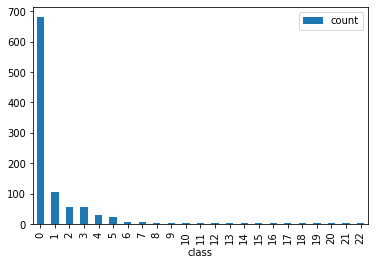

In [11]:

count_list = []
class_list = []

for i,c in enumerate(communities):
    class_list.append(i)
    count_list.append(len(list(c)))


df = pd.DataFrame({'class':class_list, 'count':count_list})
df.plot.bar(x='class', y='count')

Generating for node: Wet_Grass: 100%|██████████| 4/4 [00:00<00:00, 127.52it/s]

[bnlearn] >Checking CPDs..
[bnlearn] >Check for DAG structure. Correct: True
[bnlearn] >Forward sampling for 1000 samples..
[bnlearn] >Plot based on BayesianModel


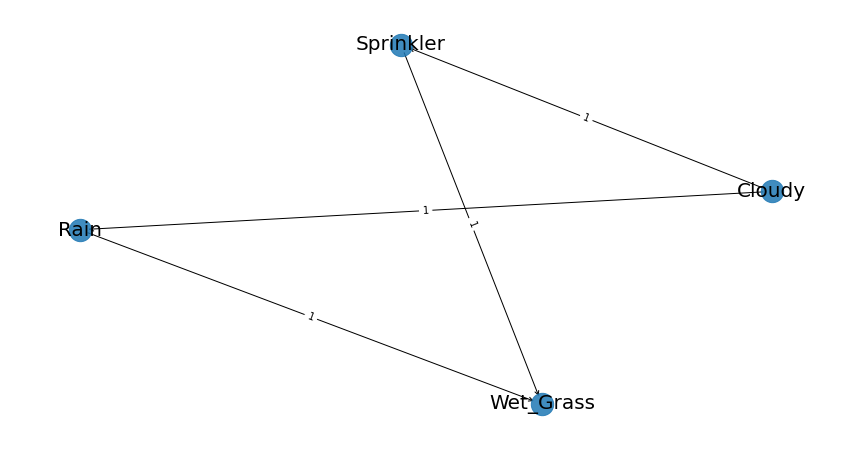

{'pos': {'Cloudy': array([0.84125178, 0.13964912]),
  'Sprinkler': array([-0.12390643,  0.92615471]),
  'Rain': array([-0.96037167, -0.06580383]),
  'Wet_Grass': array([ 0.24302633, -1.        ])},
 'G': <networkx.classes.digraph.DiGraph at 0x7fd0e28a40d0>}

In [2]:

# The following models can be loaded:
loadfile = 'sprinkler'
#loadfile = 'alarm'
#loadfile = 'andes'
#loadfile = 'asia'
#loadfile = 'sachs'


DAG = bnlearn.import_DAG(loadfile, CPD=True)

df = bnlearn.sampling(DAG, n=1000)

df.head()

bnlearn.plot(DAG)

In [9]:
#df_small = df.iloc[:, 0:20]
df_small = df.copy()
df_small.head()

,Cloudy,Rain,Sprinkler,Wet_Grass
0,1,0,0,0
1,1,1,0,1
2,1,1,0,1
3,1,0,0,0
4,0,0,0,0


In [47]:
#model = BayesianNetwork.from_samples(df_small, algorithm='exact')

In [51]:
# Funtion to evaluate the learned model structures.
def get_f1_score(estimated_model, true_model):
    nodes = estimated_model.nodes()
    est_adj = nx.to_numpy_matrix(estimated_model.to_undirected(), nodelist=nodes, weight=None)
    true_adj = nx.to_numpy_matrix(true_model.to_undirected(), nodelist=nodes, weight=None)
    
    f1 = f1_score(np.ravel(true_adj), np.ravel(est_adj))
    print("F1-score for the model skeleton: ", f1)
    
def plot_network(model):
    nx.draw(model, with_labels=True)
    plt.show()


Working for n conditional variables: 3:  75%|███████▌  | 3/4 [00:00<00:00, 18.42it/s]


In [19]:

scoring_method = K2Score(data=df_small)
est = HillClimbSearch(data=df_small)
estimated_model = est.estimate(scoring_method=scoring_method, max_indegree=4, max_iter=int(1e4))

  0%|          | 7/10000 [00:00<03:05, 53.86it/s]


In [23]:
estimated_model.edges()

OutEdgeView([('Rain', 'Cloudy'), ('Sprinkler', 'Cloudy'), ('Sprinkler', 'Wet_Grass'), ('Sprinkler', 'Rain'), ('Wet_Grass', 'Rain'), ('Wet_Grass', 'Cloudy')])

In [26]:
est.estimate(max_indegree=2).edges()

  0%|          | 5/1000000 [00:00<5:39:25, 49.10it/s]


OutEdgeView([('Cloudy', 'Rain'), ('Sprinkler', 'Cloudy'), ('Sprinkler', 'Wet_Grass'), ('Wet_Grass', 'Rain'), ('Wet_Grass', 'Cloudy')])

In [54]:
model = BayesianModel([('Cloudy', 'Rain'), ('Sprinkler', 'Cloudy'), ('Sprinkler', 'Wet_Grass'), ('Wet_Grass', 'Rain'), ('Wet_Grass', 'Cloudy')])

print(MaximumLikelihoodEstimator(model, df_small).estimate_cpd('Cloudy'))

+-----------+---------------------+---------------------+----------------------+---------------------+
| Sprinkler | Sprinkler(0)        | Sprinkler(0)        | Sprinkler(1)         | Sprinkler(1)        |
+-----------+---------------------+---------------------+----------------------+---------------------+
| Wet_Grass | Wet_Grass(0)        | Wet_Grass(1)        | Wet_Grass(0)         | Wet_Grass(1)        |
+-----------+---------------------+---------------------+----------------------+---------------------+
| Cloudy(0) | 0.6208955223880597  | 0.13672922252010725 | 0.9523809523809523   | 0.8376383763837638  |
+-----------+---------------------+---------------------+----------------------+---------------------+
| Cloudy(1) | 0.37910447761194027 | 0.8632707774798928  | 0.047619047619047616 | 0.16236162361623616 |
+-----------+---------------------+---------------------+----------------------+---------------------+


In [42]:

scoring_method = BicScore(data=df_small)
scoring_method.score(estimated_model)

-1952.183093738699

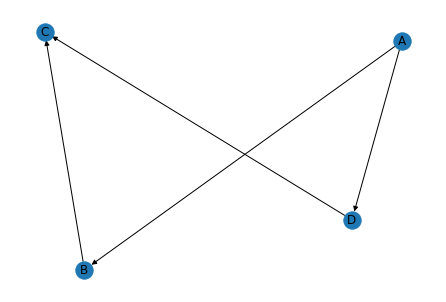

In [53]:
plot_network(model)

In [58]:
estimator = BayesianEstimator(model, df_small)
print(estimator.estimate_cpd('Cloudy', prior_type="K2"))

+-----------+--------------------+---------------------+---------------------+---------------------+
| Sprinkler | Sprinkler(0)       | Sprinkler(0)        | Sprinkler(1)        | Sprinkler(1)        |
+-----------+--------------------+---------------------+---------------------+---------------------+
| Wet_Grass | Wet_Grass(0)       | Wet_Grass(1)        | Wet_Grass(0)        | Wet_Grass(1)        |
+-----------+--------------------+---------------------+---------------------+---------------------+
| Cloudy(0) | 0.6201780415430267 | 0.13866666666666666 | 0.9130434782608695  | 0.8351648351648352  |
+-----------+--------------------+---------------------+---------------------+---------------------+
| Cloudy(1) | 0.3798219584569733 | 0.8613333333333333  | 0.08695652173913043 | 0.16483516483516483 |
+-----------+--------------------+---------------------+---------------------+---------------------+


Building tree: 100%|██████████| 6/6.0 [00:00<00:00, 2556.46it/s]


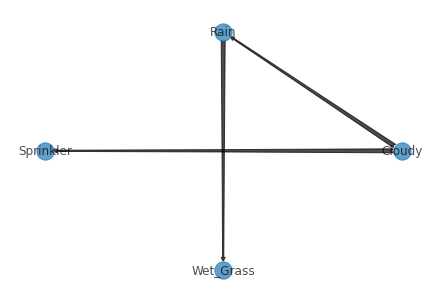

In [69]:
est = TreeSearch(df_small, root_node='Cloudy')
model = est.estimate(estimator_type='chow-liu')
nx.draw_circular(model, with_labels=True, arrowsize=10, arrowstyle='fancy',
                 alpha=0.7)
plt.show()

In [97]:
import pandas as pd
import numpy as np


chi_square(X='Cloudy', Y='Wet_Grass', Z=['Rain'], data=df_small,significance_level=0.05, boolean=False)


(43.14718340394357, 2, 4.2727565929823186e-10)